<a href="https://colab.research.google.com/github/mdparvex/brainTumorClassification/blob/main/Final_Kfold_BTC_499A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout,BatchNormalization 
from keras.preprocessing.image import ImageDataGenerator
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
#import splitfolders
import os
import cv2
import numpy as np
import random

In [ ]:
%tensorflow_version 2.x
tf.test.gpu_device_name()


'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
labels = ['glioma', 'meningioma', 'pituitary']
img_size = 128
def get_data(data_dir):
    data = []
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
train = get_data('/content/drive/MyDrive/Colab Notebooks/splited_Train_Test/train')
#test = get_data('/content/drive/MyDrive/Colab Notebooks/splited_Train_Test/test')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


In [ ]:
#X=np.asarray(train)
#Y=np.asarray(val)
train.shape

(2767, 2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


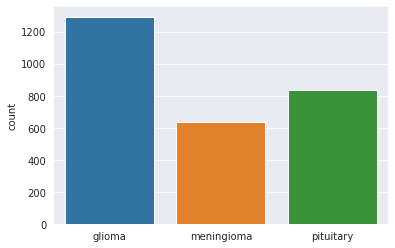

In [ ]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("glioma")
    elif(i[1]==1):
        l.append('meningioma')
    else:
        l.append("pituitary")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'glioma')

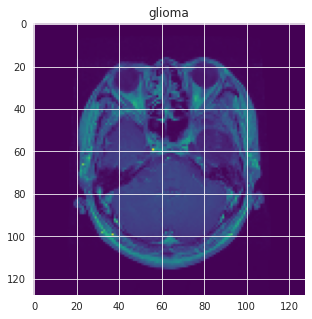

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

Text(0.5, 1.0, 'pituitary')

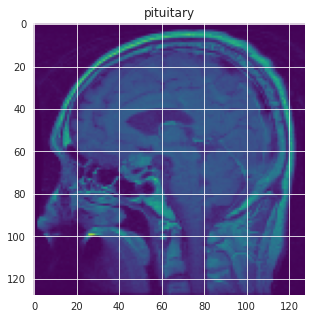

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

In [ ]:

x_train = []
y_train = []
#x_test = []
#y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

#for feature, label in test:
 #   x_test.append(feature)
  #  y_test.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
#x_test = np.array(x_test) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

#x_test.reshape(-1, img_size, img_size, 1)
#y_test = np.array(y_test)

In [ ]:
#x_train.shape
#x_train.shape
y_train.shape

(2767,)

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.3, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,
        fill_mode='nearest',  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [ ]:
def get_model():

  model = Sequential()
  model.add(Conv2D(64,3,padding="same", activation="relu", input_shape=(128,128,3)))
  model.add(MaxPool2D())

  model.add(Conv2D(64, 3, padding="same", activation="relu"))
  model.add(MaxPool2D())
  model.add(Dropout(0.2))

  #model.add(Conv2D(64, 3, padding="same", activation="relu"))
  #model.add(BatchNormalization())
  #model.add(MaxPool2D())

  model.add(Conv2D(128, 3, padding="same", activation="relu"))
  model.add(BatchNormalization())
  model.add(MaxPool2D())

  model.add(Conv2D(128, 3, padding="same", activation="relu"))
  model.add(MaxPool2D())
  model.add(Dropout(0.2))


  model.add(Flatten())
  model.add(Dense(128,activation="relu"))
  model.add(Dense(64, activation="relu"))
  model.add(Dense(3, activation="softmax"))

  return model

model=get_model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       7

In [ ]:
# Merge inputs and targets
#inputs = np.concatenate((x_train, x_val), axis=0)
#targets = np.concatenate((y_train, y_val), axis=0)

# Define the K-fold Cross Validator
#kfold = KFold(n_splits=10, shuffle=True)

#skf = StratifiedKFold(n_splits=3, shuffle=True)
#skf.get_n_splits(X, Y)
#K.clear_session()
#cuda.select_device(0)
#cuda.close()
from keras import backend as K
import gc

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
44/44 [==============================] - 16s 119ms/step - loss: 0.7983 - accuracy: 0.6353 - val_loss: 1.0529 - val_accuracy: 0.7545
Epoch 2/100
44/44 [==============================] - 4s 94ms/step - loss: 0.5533 - accuracy: 0.7604 - val_loss: 1.0077 - val_accuracy: 0.7762
Epoch 3/100
44/44 [==============================] - 4s 93ms/step - loss: 0.4834 - accuracy: 0.7951 - val_loss: 0.9840 - val_accuracy: 0.8195
Epoch 4/100
44/44 [==============================] - 4s 94ms/step - loss: 0.4456 - accuracy: 0.8052 - val_loss: 0.9601 - val_accuracy: 0.7978
Epoch 5/100
44/44 [==============================] - 4s 93ms/step - loss: 0.3901 - accuracy: 0.8301 - val_loss: 0.8823 - val_accuracy: 0.8845
Epoch 6/100
44/44 [==============================] - 4s 93ms/step - loss: 0.3646 - accuracy: 0.8442 - val_loss: 0.8275 - val_accuracy: 0.8881
Epoch 7/100
44/44 [==============================

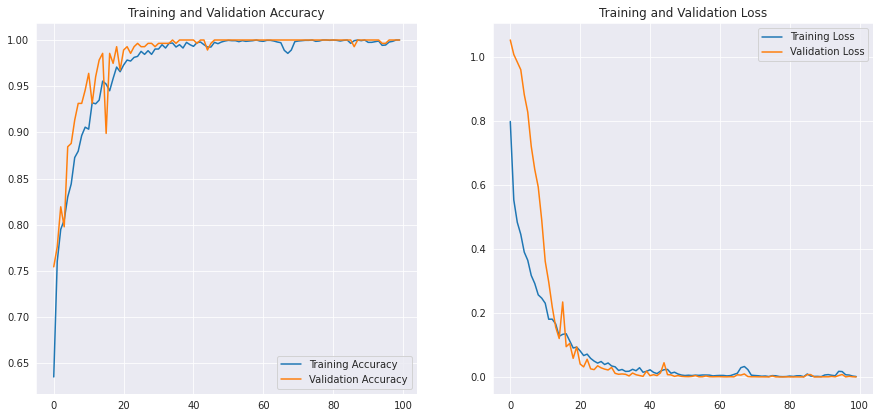

------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/100
44/44 [==============================] - 5s 99ms/step - loss: 0.0126 - accuracy: 0.9946 - val_loss: 3.1281e-04 - val_accuracy: 1.0000
Epoch 2/100
44/44 [==============================] - 4s 94ms/step - loss: 0.0025 - accuracy: 0.9993 - val_loss: 1.1899e-04 - val_accuracy: 1.0000
Epoch 3/100
44/44 [==============================] - 4s 94ms/step - loss: 8.9443e-04 - accuracy: 1.0000 - val_loss: 2.0821e-04 - val_accuracy: 1.0000
Epoch 4/100
44/44 [==============================] - 4s 94ms/step - loss: 0.0050 - accuracy: 0.9978 - val_loss: 3.7470e-04 - val_accuracy: 1.0000
Epoch 5/100
44/44 [==============================] - 4s 94ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 8.5824e-05 - val_accuracy: 1.0000
Epoch 6/100
44/44 [==============================] - 4s 94ms/step - loss: 0.0012 - accuracy: 0.9996 - val_loss: 2.2835e-04 - val_accuracy: 1.0000
Epoch 7/100
44/44 [====

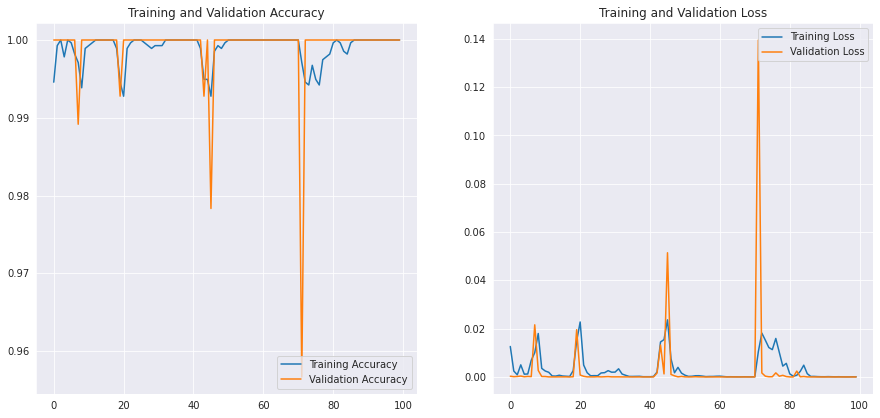

------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/100
44/44 [==============================] - 5s 102ms/step - loss: 9.6833e-04 - accuracy: 0.9996 - val_loss: 1.9513e-04 - val_accuracy: 1.0000
Epoch 2/100
44/44 [==============================] - 4s 94ms/step - loss: 0.0020 - accuracy: 0.9993 - val_loss: 1.3666e-04 - val_accuracy: 1.0000
Epoch 3/100
44/44 [==============================] - 4s 95ms/step - loss: 0.0028 - accuracy: 0.9989 - val_loss: 1.9531e-05 - val_accuracy: 1.0000
Epoch 4/100
44/44 [==============================] - 4s 94ms/step - loss: 0.0024 - accuracy: 0.9993 - val_loss: 5.9587e-06 - val_accuracy: 1.0000
Epoch 5/100
44/44 [==============================] - 4s 95ms/step - loss: 4.3347e-04 - accuracy: 1.0000 - val_loss: 2.3859e-06 - val_accuracy: 1.0000
Epoch 6/100
44/44 [==============================] - 4s 94ms/step - loss: 3.0944e-04 - accuracy: 1.0000 - val_loss: 5.3528e-06 - val_accuracy: 1.0000
Epoch 7/100
44

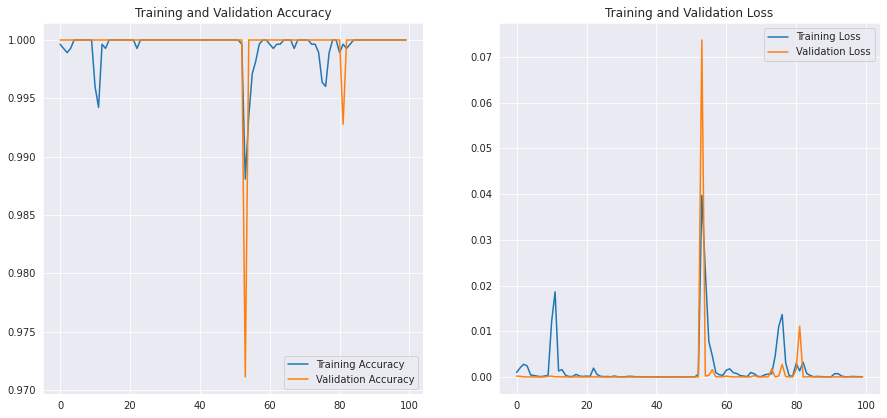

------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/100
44/44 [==============================] - 5s 101ms/step - loss: 9.2042e-04 - accuracy: 0.9996 - val_loss: 3.7220e-05 - val_accuracy: 1.0000
Epoch 2/100
44/44 [==============================] - 4s 95ms/step - loss: 0.0027 - accuracy: 0.9989 - val_loss: 1.0698e-06 - val_accuracy: 1.0000
Epoch 3/100
44/44 [==============================] - 4s 95ms/step - loss: 6.7509e-04 - accuracy: 0.9996 - val_loss: 0.0166 - val_accuracy: 0.9964
Epoch 4/100
44/44 [==============================] - 4s 94ms/step - loss: 0.0013 - accuracy: 0.9993 - val_loss: 1.9214e-06 - val_accuracy: 1.0000
Epoch 5/100
44/44 [==============================] - 4s 95ms/step - loss: 7.0203e-04 - accuracy: 0.9993 - val_loss: 3.6201e-06 - val_accuracy: 1.0000
Epoch 6/100
44/44 [==============================] - 4s 94ms/step - loss: 0.0068 - accuracy: 0.9986 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 7/100
44/44 [===

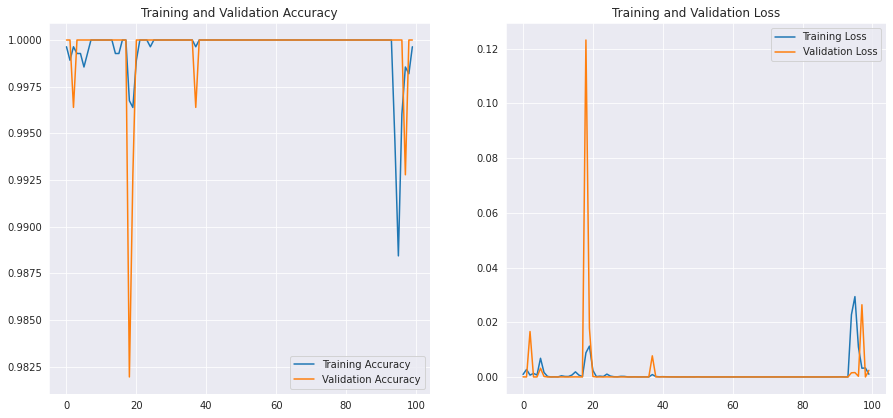

------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/100
44/44 [==============================] - 5s 103ms/step - loss: 0.0019 - accuracy: 0.9989 - val_loss: 4.4435e-06 - val_accuracy: 1.0000
Epoch 2/100
44/44 [==============================] - 4s 95ms/step - loss: 3.0020e-04 - accuracy: 1.0000 - val_loss: 3.5853e-05 - val_accuracy: 1.0000
Epoch 3/100
44/44 [==============================] - 4s 94ms/step - loss: 5.2598e-05 - accuracy: 1.0000 - val_loss: 1.8103e-06 - val_accuracy: 1.0000
Epoch 4/100
44/44 [==============================] - 4s 95ms/step - loss: 4.6724e-05 - accuracy: 1.0000 - val_loss: 2.1653e-06 - val_accuracy: 1.0000
Epoch 5/100
44/44 [==============================] - 4s 94ms/step - loss: 7.7961e-05 - accuracy: 1.0000 - val_loss: 1.9763e-06 - val_accuracy: 1.0000
Epoch 6/100
44/44 [==============================] - 4s 94ms/step - loss: 5.1259e-05 - accuracy: 1.0000 - val_loss: 9.3900e-07 - val_accuracy: 1.0000
Epoch 

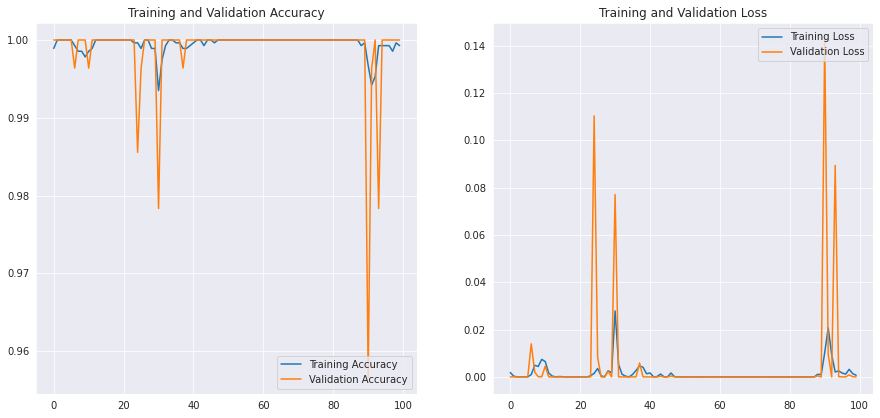

------------------------------------------------------------------------
Training for fold 6 ...
Epoch 1/100
44/44 [==============================] - 5s 101ms/step - loss: 0.0023 - accuracy: 0.9993 - val_loss: 0.0097 - val_accuracy: 0.9964
Epoch 2/100
44/44 [==============================] - 4s 94ms/step - loss: 3.1218e-04 - accuracy: 1.0000 - val_loss: 4.4281e-07 - val_accuracy: 1.0000
Epoch 3/100
44/44 [==============================] - 4s 95ms/step - loss: 8.9620e-04 - accuracy: 0.9996 - val_loss: 7.5312e-08 - val_accuracy: 1.0000
Epoch 4/100
44/44 [==============================] - 4s 95ms/step - loss: 1.0972e-05 - accuracy: 1.0000 - val_loss: 7.9185e-08 - val_accuracy: 1.0000
Epoch 5/100
44/44 [==============================] - 4s 95ms/step - loss: 6.6062e-06 - accuracy: 1.0000 - val_loss: 2.1948e-08 - val_accuracy: 1.0000
Epoch 6/100
44/44 [==============================] - 4s 95ms/step - loss: 0.0028 - accuracy: 0.9989 - val_loss: 2.3565e-06 - val_accuracy: 1.0000
Epoch 7/100
44

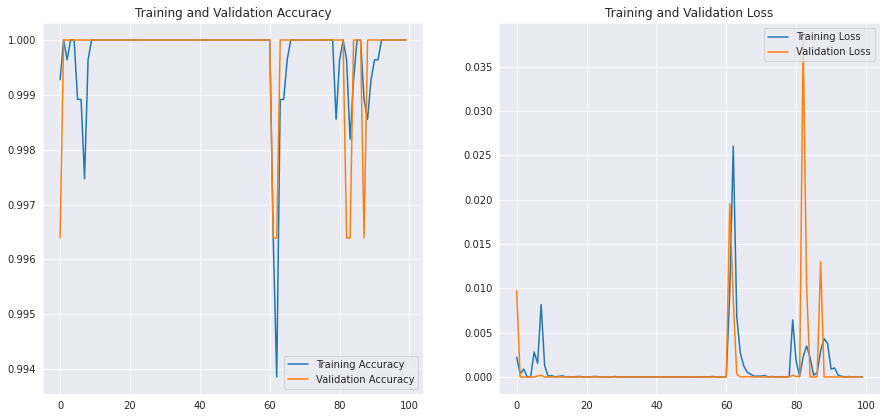

------------------------------------------------------------------------
Training for fold 7 ...
Epoch 1/100
44/44 [==============================] - 6s 103ms/step - loss: 5.0564e-05 - accuracy: 1.0000 - val_loss: 7.7465e-09 - val_accuracy: 1.0000
Epoch 2/100
44/44 [==============================] - 4s 95ms/step - loss: 1.6487e-05 - accuracy: 1.0000 - val_loss: 1.8505e-08 - val_accuracy: 1.0000
Epoch 3/100
44/44 [==============================] - 4s 96ms/step - loss: 5.1822e-06 - accuracy: 1.0000 - val_loss: 2.1518e-08 - val_accuracy: 1.0000
Epoch 4/100
44/44 [==============================] - 4s 96ms/step - loss: 1.1357e-05 - accuracy: 1.0000 - val_loss: 8.6072e-10 - val_accuracy: 1.0000
Epoch 5/100
44/44 [==============================] - 4s 94ms/step - loss: 8.6411e-07 - accuracy: 1.0000 - val_loss: 4.3036e-10 - val_accuracy: 1.0000
Epoch 6/100
44/44 [==============================] - 4s 96ms/step - loss: 2.5840e-07 - accuracy: 1.0000 - val_loss: 4.3036e-10 - val_accuracy: 1.0000
Ep

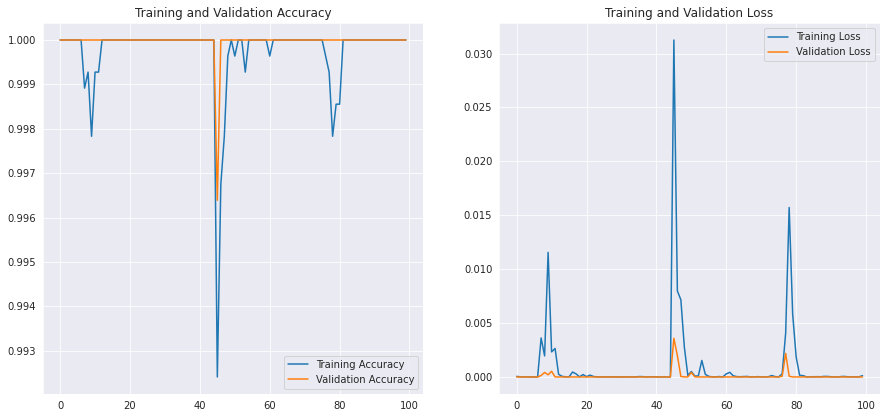

------------------------------------------------------------------------
Training for fold 8 ...
Epoch 1/100
44/44 [==============================] - 6s 109ms/step - loss: 9.0297e-05 - accuracy: 1.0000 - val_loss: 6.4699e-07 - val_accuracy: 1.0000
Epoch 2/100
44/44 [==============================] - 4s 95ms/step - loss: 1.8524e-05 - accuracy: 1.0000 - val_loss: 6.3923e-08 - val_accuracy: 1.0000
Epoch 3/100
44/44 [==============================] - 4s 95ms/step - loss: 1.7670e-04 - accuracy: 1.0000 - val_loss: 1.1230e-08 - val_accuracy: 1.0000
Epoch 4/100
44/44 [==============================] - 4s 95ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 3.7916e-06 - val_accuracy: 1.0000
Epoch 5/100
44/44 [==============================] - 4s 94ms/step - loss: 3.6718e-05 - accuracy: 1.0000 - val_loss: 3.2315e-06 - val_accuracy: 1.0000
Epoch 6/100
44/44 [==============================] - 4s 96ms/step - loss: 3.1228e-06 - accuracy: 1.0000 - val_loss: 2.0300e-08 - val_accuracy: 1.0000
Epoch 

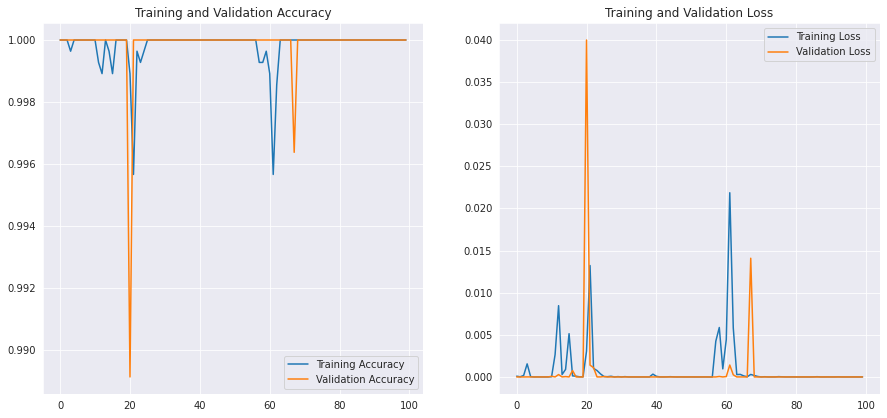

------------------------------------------------------------------------
Training for fold 9 ...
Epoch 1/100
44/44 [==============================] - 5s 101ms/step - loss: 1.1789e-05 - accuracy: 1.0000 - val_loss: 4.8806e-08 - val_accuracy: 1.0000
Epoch 2/100
44/44 [==============================] - 4s 94ms/step - loss: 7.5205e-05 - accuracy: 1.0000 - val_loss: 7.1910e-07 - val_accuracy: 1.0000
Epoch 3/100
44/44 [==============================] - 4s 95ms/step - loss: 3.4993e-04 - accuracy: 1.0000 - val_loss: 1.1042e-04 - val_accuracy: 1.0000
Epoch 4/100
44/44 [==============================] - 4s 95ms/step - loss: 0.0072 - accuracy: 0.9993 - val_loss: 3.7013e-05 - val_accuracy: 1.0000
Epoch 5/100
44/44 [==============================] - 4s 95ms/step - loss: 1.7420e-04 - accuracy: 1.0000 - val_loss: 5.6149e-09 - val_accuracy: 1.0000
Epoch 6/100
44/44 [==============================] - 4s 94ms/step - loss: 1.8550e-04 - accuracy: 1.0000 - val_loss: 1.7277e-09 - val_accuracy: 1.0000
Epoch 

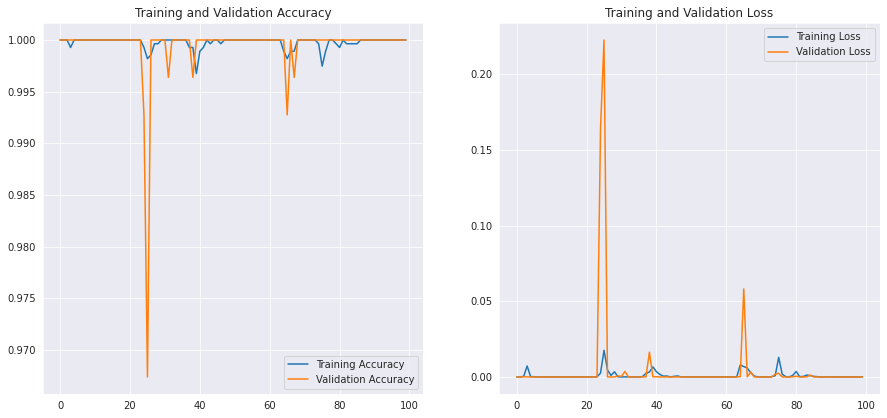

------------------------------------------------------------------------
Training for fold 10 ...
Epoch 1/100
44/44 [==============================] - 5s 104ms/step - loss: 9.2744e-06 - accuracy: 1.0000 - val_loss: 8.6384e-10 - val_accuracy: 1.0000
Epoch 2/100
44/44 [==============================] - 4s 95ms/step - loss: 2.1305e-04 - accuracy: 1.0000 - val_loss: 4.9784e-05 - val_accuracy: 1.0000
Epoch 3/100
44/44 [==============================] - 4s 96ms/step - loss: 5.3745e-07 - accuracy: 1.0000 - val_loss: 1.7709e-08 - val_accuracy: 1.0000
Epoch 4/100
44/44 [==============================] - 4s 96ms/step - loss: 8.5271e-07 - accuracy: 1.0000 - val_loss: 2.0732e-08 - val_accuracy: 1.0000
Epoch 5/100
44/44 [==============================] - 4s 96ms/step - loss: 1.6232e-07 - accuracy: 1.0000 - val_loss: 1.5549e-08 - val_accuracy: 1.0000
Epoch 6/100
44/44 [==============================] - 4s 96ms/step - loss: 5.0867e-07 - accuracy: 1.0000 - val_loss: 1.8572e-08 - val_accuracy: 1.0000
E

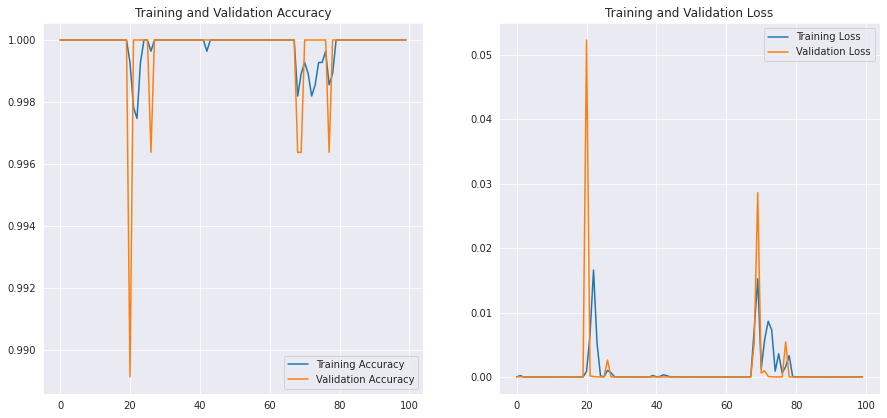

In [ ]:
##-----------------sklearn------------##
acc_per_fold=[]
loss_per_fold=[]

X = x_train
y = y_train
kf = KFold(n_splits=10,shuffle=True)
#print(kf.get_n_splits(X))
#print(kf)
#print(X.shape)
#print(y.shape)
#KFold(n_splits=2, random_state=None, shuffle=False)
fold_no = 1
for train_index, test_index in kf.split(X):

  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train_kf, X_val_kf = X[train_index], X[test_index]
  y_train_kf, y_val_kf = y[train_index], y[test_index]

  opt = Adam(learning_rate=0.0001)
  model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) , metrics = ['accuracy'])
  
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  history = model.fit(x_train,y_train,epochs = 100,batch_size=64 , validation_data = (X_val_kf, y_val_kf))
  

  scores = model.evaluate(X_val_kf,y_val_kf , verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  model.save("model"+str(fold_no)+".h5")

  #loss accuracy graph
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(100)

  plt.figure(figsize=(15, 15))
  plt.subplot(2, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()


  #clear session
  tf.keras.backend.clear_session()
  #gc.collect()

  fold_no = fold_no + 1

In [ ]:
print(acc_per_fold)

[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


In [ ]:
print(sum(acc_per_fold)/len(acc_per_fold))

100.0


In [ ]:
print(loss_per_fold)

[0.0001633057981962338, 1.3112814940541284e-06, 4.0152036717699957e-07, 0.002419488038867712, 9.010180292534642e-06, 5.1643005427592925e-09, 1.8419156333493447e-07, 1.7276704511459684e-09, 1.8269990675889858e-07, 0.0]


In [ ]:
print(sum(loss_per_fold)/len(loss_per_fold))

0.0002593890602658799


In [ ]:
test_data_dir= '/content/drive/MyDrive/Colab Notebooks/splited_Train_Test/test'
test_generator = ImageDataGenerator().flow_from_directory(test_data_dir
                                                           , target_size=(128, 128)
                                                           , batch_size=5
                                                           , classes=labels
                                                           , seed=0
                                                           , shuffle=False)

Found 308 images belonging to 3 classes.


In [ ]:
model=tf.keras.models.load_model('model1.h5')

In [ ]:
#probability_model = tf.keras.Sequential([model, 
 #                                        tf.keras.layers.Softmax()])

In [ ]:
#print(probability_model)

In [ ]:
#predictions = probability_model.predict(test_generator)

In [ ]:
#print(predictions)

In [ ]:
actual = test_generator.classes

In [ ]:
print(actual)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2]


In [ ]:

predict = np.argmax(model.predict(test_generator),axis =1)

In [ ]:
print(predict)

[0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 2 1 2 2 1 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 1]


Confusion matrix

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report


(<Figure size 576x576 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff485e77a10>)

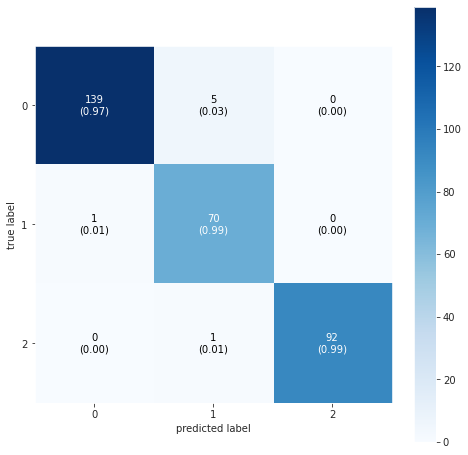

In [ ]:
cm=confusion_matrix(actual,predict)
plot_confusion_matrix(cm,figsize=(8,8),
                      colorbar=True,show_normed=True,)

Precission, Recall, F1 score

In [ ]:
print(classification_report(actual,predict))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       144
           1       0.92      0.99      0.95        71
           2       1.00      0.99      0.99        93

    accuracy                           0.98       308
   macro avg       0.97      0.98      0.98       308
weighted avg       0.98      0.98      0.98       308



In [ ]:
actual = test_generator.classes
predict = np.argmax(model.predict(test_generator),axis =1)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       144
           1       0.92      0.99      0.95        71
           2       1.00      0.99      0.99        93

    accuracy                           0.98       308
   macro avg       0.97      0.98      0.98       308
weighted avg       0.98      0.98      0.98       308



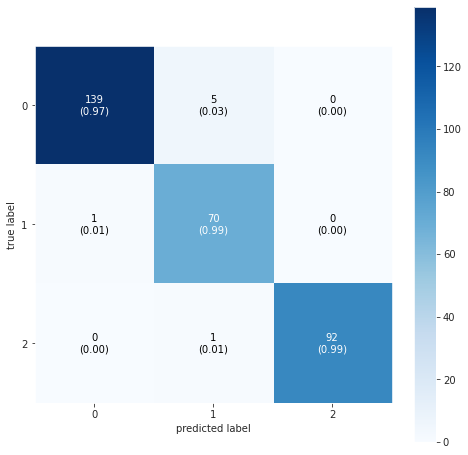

In [ ]:
model=tf.keras.models.load_model('model1.h5')
actual = test_generator.classes
predict = np.argmax(model.predict(test_generator),axis =1)
cm=confusion_matrix(actual,predict)
plot_confusion_matrix(cm,figsize=(8,8),
                    colorbar=True,show_normed=True,)
#value
print(classification_report(actual,predict))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       144
           1       0.95      0.99      0.97        71
           2       1.00      0.98      0.99        93

    accuracy                           0.98       308
   macro avg       0.98      0.98      0.98       308
weighted avg       0.98      0.98      0.98       308



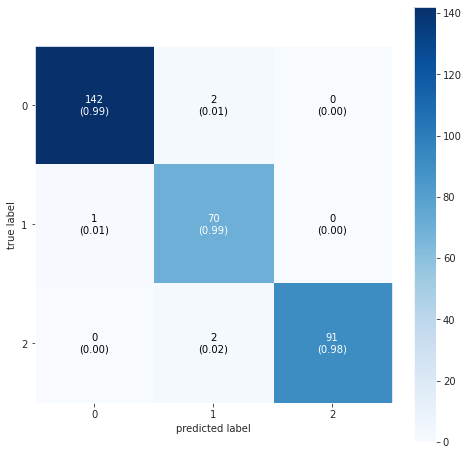

In [ ]:
model=tf.keras.models.load_model('model2.h5')
actual = test_generator.classes
predict = np.argmax(model.predict(test_generator),axis =1)
cm=confusion_matrix(actual,predict)
plot_confusion_matrix(cm,figsize=(8,8),
                    colorbar=True,show_normed=True,)

print(classification_report(actual,predict))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       144
           1       0.96      0.99      0.97        71
           2       0.99      1.00      0.99        93

    accuracy                           0.98       308
   macro avg       0.98      0.99      0.98       308
weighted avg       0.98      0.98      0.98       308



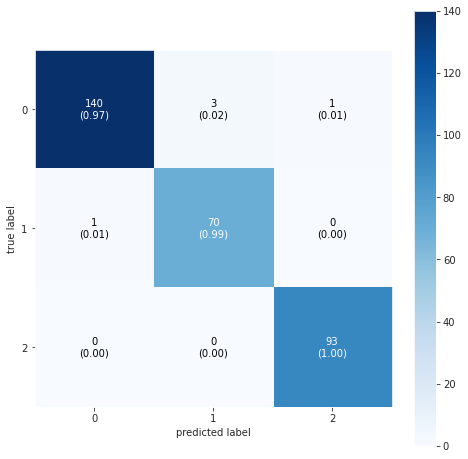

In [ ]:
model=tf.keras.models.load_model('model3.h5')
actual = test_generator.classes
predict = np.argmax(model.predict(test_generator),axis =1)
cm=confusion_matrix(actual,predict)
plot_confusion_matrix(cm,figsize=(8,8),
                    colorbar=True,show_normed=True,)

print(classification_report(actual,predict))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       144
           1       0.96      0.99      0.97        71
           2       0.99      0.99      0.99        93

    accuracy                           0.98       308
   macro avg       0.98      0.98      0.98       308
weighted avg       0.98      0.98      0.98       308



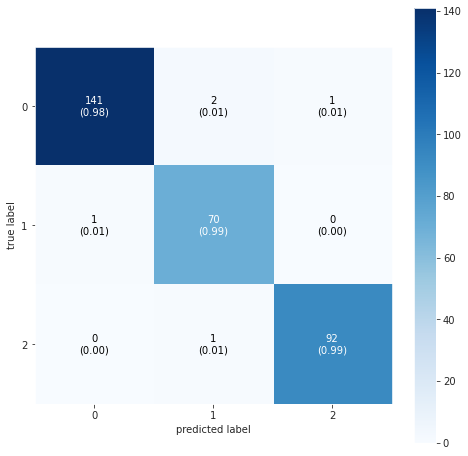

In [ ]:
model=tf.keras.models.load_model('model4.h5')
actual = test_generator.classes
predict = np.argmax(model.predict(test_generator),axis =1)
cm=confusion_matrix(actual,predict)
plot_confusion_matrix(cm,figsize=(8,8),
                    colorbar=True,show_normed=True,)

print(classification_report(actual,predict))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       144
           1       0.96      0.97      0.97        71
           2       0.99      0.99      0.99        93

    accuracy                           0.98       308
   macro avg       0.98      0.98      0.98       308
weighted avg       0.98      0.98      0.98       308



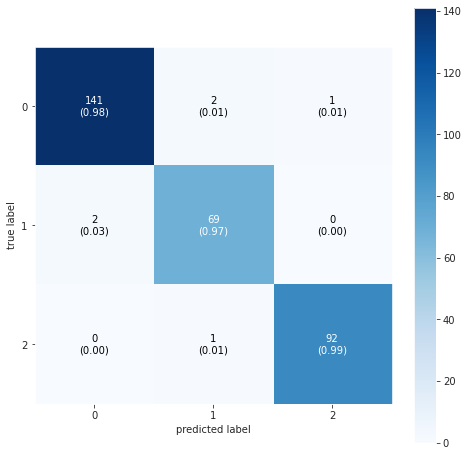

In [ ]:
model=tf.keras.models.load_model('model5.h5')
actual = test_generator.classes
predict = np.argmax(model.predict(test_generator),axis =1)
cm=confusion_matrix(actual,predict)
plot_confusion_matrix(cm,figsize=(8,8),
                    colorbar=True,show_normed=True,)

print(classification_report(actual,predict))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       144
           1       0.97      1.00      0.99        71
           2       0.99      0.99      0.99        93

    accuracy                           0.99       308
   macro avg       0.98      0.99      0.99       308
weighted avg       0.99      0.99      0.99       308



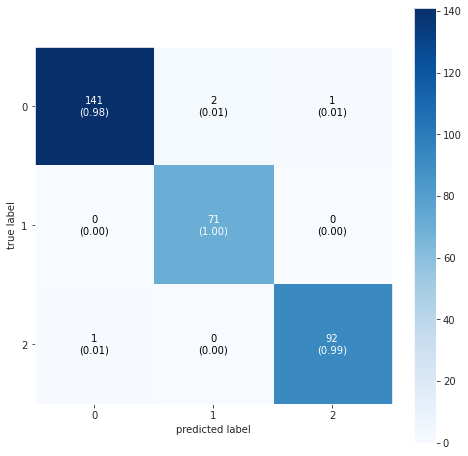

In [ ]:
model=tf.keras.models.load_model('model6.h5')
actual = test_generator.classes
predict = np.argmax(model.predict(test_generator),axis =1)
cm=confusion_matrix(actual,predict)
plot_confusion_matrix(cm,figsize=(8,8),
                    colorbar=True,show_normed=True,)

print(classification_report(actual,predict))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       144
           1       1.00      0.96      0.98        71
           2       1.00      0.99      0.99        93

    accuracy                           0.99       308
   macro avg       0.99      0.98      0.99       308
weighted avg       0.99      0.99      0.99       308



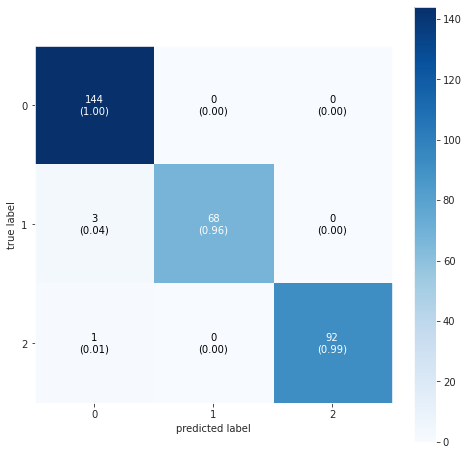

In [ ]:
model=tf.keras.models.load_model('model7.h5')
actual = test_generator.classes
predict = np.argmax(model.predict(test_generator),axis =1)
cm=confusion_matrix(actual,predict)
plot_confusion_matrix(cm,figsize=(8,8),
                    colorbar=True,show_normed=True,)

print(classification_report(actual,predict))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       144
           1       0.93      1.00      0.97        71
           2       0.99      1.00      0.99        93

    accuracy                           0.98       308
   macro avg       0.97      0.99      0.98       308
weighted avg       0.98      0.98      0.98       308



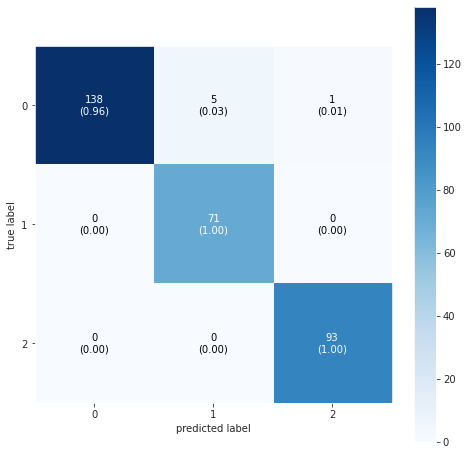

In [ ]:
model=tf.keras.models.load_model('model8.h5')
actual = test_generator.classes
predict = np.argmax(model.predict(test_generator),axis =1)
cm=confusion_matrix(actual,predict)
plot_confusion_matrix(cm,figsize=(8,8),
                    colorbar=True,show_normed=True,)

print(classification_report(actual,predict))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       144
           1       0.95      0.99      0.97        71
           2       0.99      1.00      0.99        93

    accuracy                           0.98       308
   macro avg       0.98      0.98      0.98       308
weighted avg       0.98      0.98      0.98       308



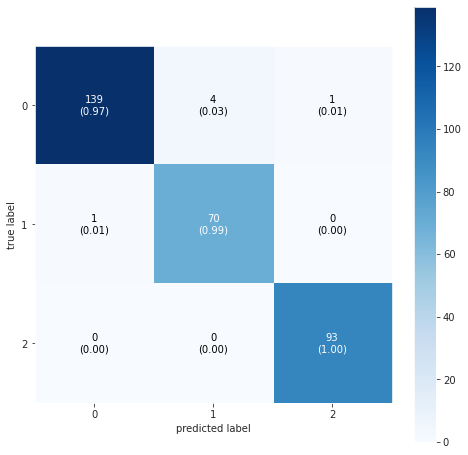

In [ ]:
model=tf.keras.models.load_model('model9.h5')
actual = test_generator.classes
predict = np.argmax(model.predict(test_generator),axis =1)
cm=confusion_matrix(actual,predict)
plot_confusion_matrix(cm,figsize=(8,8),
                    colorbar=True,show_normed=True,)

print(classification_report(actual,predict))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       144
           1       0.96      0.99      0.97        71
           2       0.99      1.00      0.99        93

    accuracy                           0.98       308
   macro avg       0.98      0.99      0.98       308
weighted avg       0.98      0.98      0.98       308



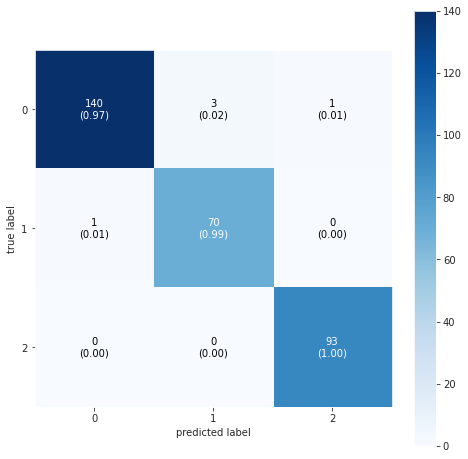

In [ ]:
model=tf.keras.models.load_model('model10.h5')
actual = test_generator.classes
predict = np.argmax(model.predict(test_generator),axis =1)
cm=confusion_matrix(actual,predict)
plot_confusion_matrix(cm,figsize=(8,8),
                    colorbar=True,show_normed=True,)

print(classification_report(actual,predict))